# Notebookの検索

## NBSearchの準備

### MongoDBの用意

NBSearchはMongoDBをバックエンドとして利用します。実際の場面で利用する場合は、Jupyterコンテナとは別にMongoDBコンテナを用意してください。
dockerコマンドでは以下のようにMongoDBコンテナを用意し、Jupyterコンテナに接続してください。

```
docker run -d --rm --name nbsearch-mongodb mongo
docker run -it --rm --link nbsearch-mongodb:mymongo -e NBSEARCHDB_HOSTNAME=mymongo -p 8888:8888 niicloudoperation/notebook
```

なお、NBSearchにMongoDBの設定を与えるためには、以下の環境変数を利用することができます。

- `-e NBSEARCHDB_HOSTNAME=your_mongodb_hostname`, `-e NBSEARCHDB_PORT=your_mongodb_port` - MongoDBのホスト名・ポート番号を指定する(default: `localhost:27017`)
- `-e NBSEARCHDB_USERNAME=your_mongodb_username`, `-e NBSEARCHDB_PASSWORD=your_mongodb_password` - MongoDBの認証用ユーザ名・パスワードを指定する(default: 認証を使用しない)
- `-e NBSEARCHDB_DATABASE=your_database_name` - MongoDBのデータベース名(default: `nbsearch`)
- `-e NBSEARCHDB_COLLECTION=your_collection_name` - MongoDBのコレクション名(default: `notebooks`)
- `-e NBSEARCHDB_BASE_DIR=your_notebook_home_dir` - 検索対象とするローカルディレクトリ(default: `/home/$NB_USER`)
- `-e NBSEARCHDB_MY_SERVER_URL=your_notebook_server_url` - このサーバURL。このサーバにあるNotebookの識別用に使用する(default: `http://localhost:8888/`)


本イメージは、動作のお試し用にMongoDBを用意しています。このコンテナ中にMongoDBを起動したい場合は、以下のセルを実行します。

In [1]:
%%bash
sed "s,{NB_USER},$NB_USER," /opt/nbsearch/mongod.conf.template > ~/.nbsearch/mongod.conf
/usr/bin/mongod --fork --config ~/.nbsearch/mongod.conf

about to fork child process, waiting until server is ready for connections.
forked process: 106
child process started successfully, parent exiting


これで、 `localhost:27017` でMongoDBにアクセス可能になります。(データベースファイルは、 `~/.nbsearch/mongodb` に作成されます)。

MongoDBを起動したら、`jupyter nbsearch update-index`コマンドを使用して、現在の作業ディレクトリ上にあるNotebookに基づきMongoDB内のコレクションを更新します。(`NBSEARCHDB_*` 環境変数がデフォルトの時のみ正常動作します)

In [2]:
%%bash
jupyter nbsearch update-index $CONDA_DIR/etc/jupyter/jupyter_notebook_config.py --debug local

[UpdateIndexApp] updating indices for local, None(/opt/conda/etc/jupyter/jupyter_notebook_config.py)
[UpdateIndexApp] Using default logger
[UpdateIndexApp] updating index for notebook... {'server': 'http://localhost:8888/', 'path': '02_AWS操作用ツールのインストール.ipynb', 'mtime': datetime.datetime(2019, 9, 27, 0, 0, 16), 'atime': datetime.datetime(2019, 9, 27, 0, 0, 16)}
[UpdateIndexApp] create: notebook={'server': 'http://localhost:8888/', 'path': '02_AWS操作用ツールのインストール.ipynb', 'mtime': datetime.datetime(2019, 9, 27, 0, 0, 16), 'atime': datetime.datetime(2019, 9, 27, 0, 0, 16)}
[UpdateIndexApp] updating index for notebook... {'server': 'http://localhost:8888/', 'path': '97_Test nbextensions.ipynb', 'mtime': datetime.datetime(2019, 9, 27, 0, 0, 16), 'atime': datetime.datetime(2019, 9, 27, 0, 0, 16)}
[UpdateIndexApp] create: notebook={'server': 'http://localhost:8888/', 'path': '97_Test nbextensions.ipynb', 'mtime': datetime.datetime(2019, 9, 27, 0, 0, 16), 'atime': datetime.datetime(2019, 9, 27, 0,

今後、作業ディレクトリ上でNotebookの変更が発生した際に、MongoDB内のコレクションを更新したい場合は、以下のセルを実行し、lsyncdプロセスを起動します。

In [3]:
!lsyncd /opt/nbsearch/update-index.lua

上記のようにlsyncdプロセスを起動するか、コンテナ起動時の環境変数に`NBSEARCHDB_AUTO_UPDATE=1`を加えることで、
ホームディレクトリ内で作成・変更したNotebookを自動的にNBSearchで検索可能になります。

### NBSearch拡張の有効化

NBSearch拡張は本イメージではデフォルトでは無効化されています。

NBextensionsタブで、 `NBSearch` 拡張のチェックを押して有効化してください。

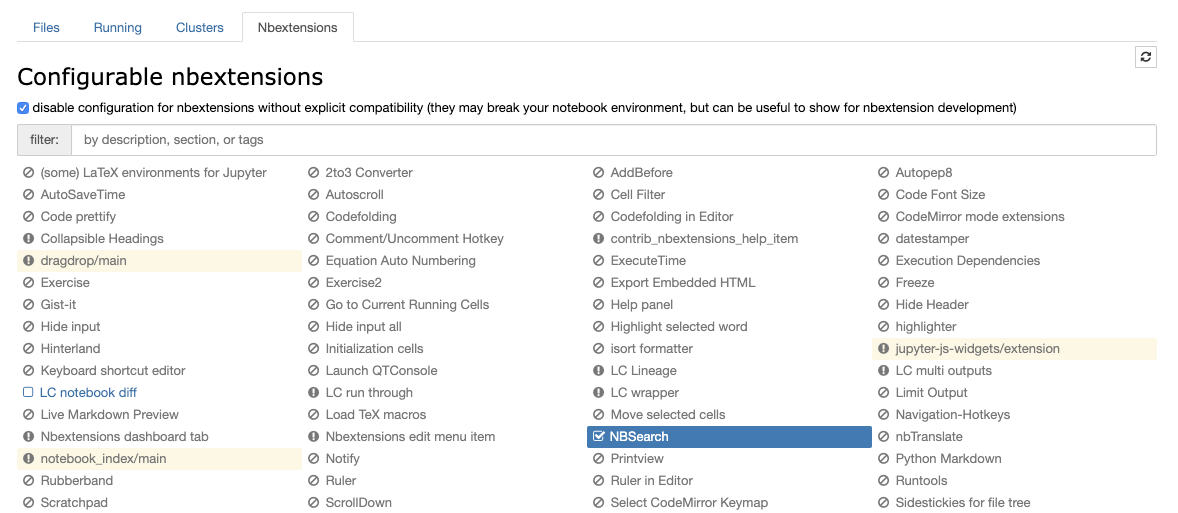


また、検索結果から `Notebookの比較` をおこないたい場合は、 `LC notebook diff` 拡張のチェックをして有効化してください。

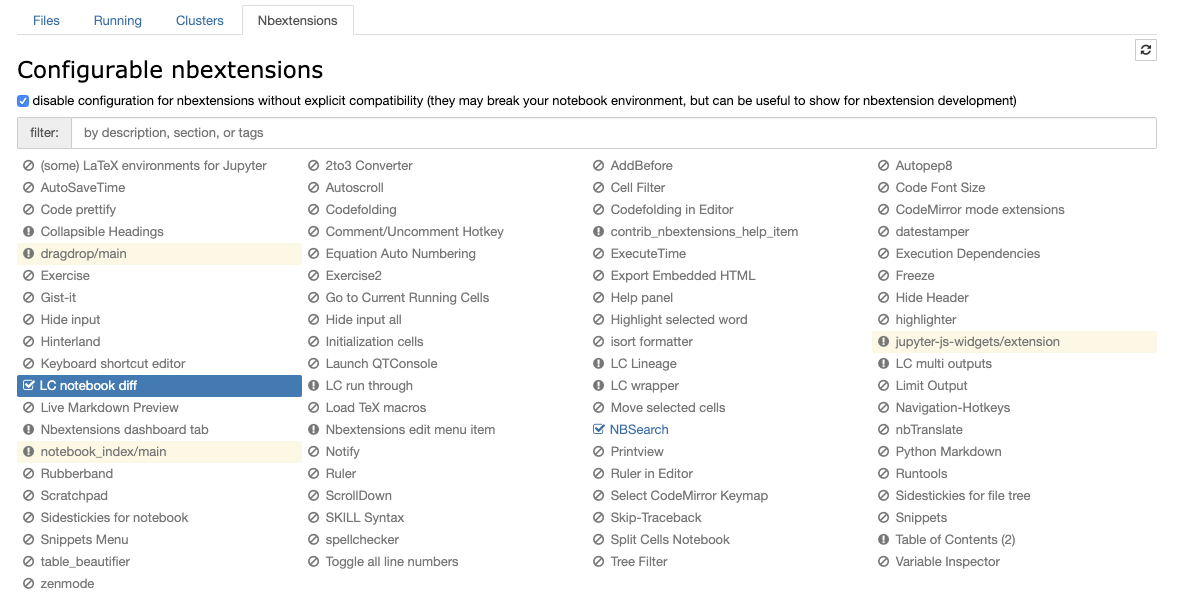

## NBSearchの使い方

*NBSearch拡張を有効化*後、ブラウザを再読み込みするとNBSearchタブが現れます。ここから、Notebookを検索することができます。

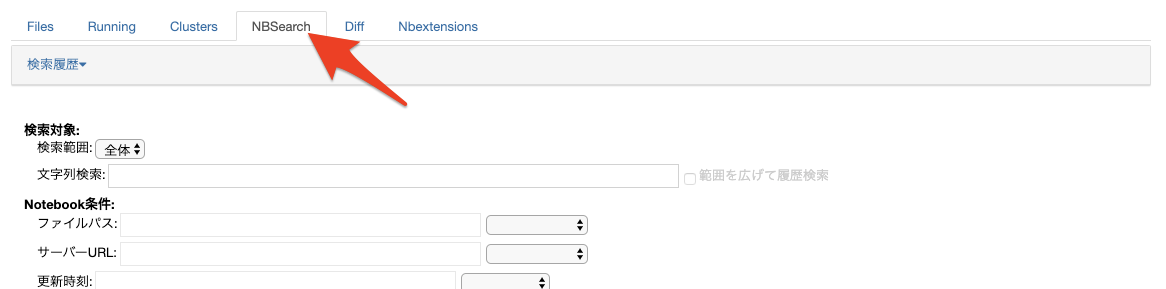

### キーワードによる検索

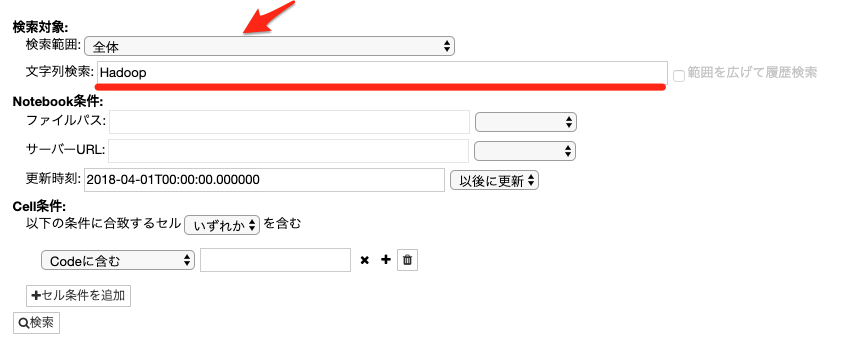

Notebook DBに保存されたNotebookを、文字列により検索します。文字列はCode Cell, Markdown Cell, Output, Pathを対象に検索されます。

キーワードによる検索は、後述する `NBSearchヒストリ` に対しては行えません。検索範囲を 全体 とした上で入力してください。

### Notebookの情報に基づく検索

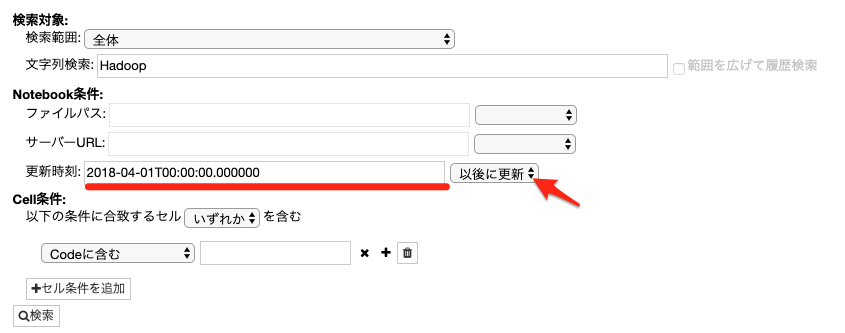

NotebookのファイルパスやサーバのURL, 更新時刻に対して検索することもできます。
まず、検索条件をドロップダウンから選択します。

* ファイルパス ... *一致* / *一致しない* / *含む* / *含まない*
* サーバーURL ... *一致* / *一致しない* / *含む* / *含まない*
* 更新時刻 ... *以前* / *以後* で選択、検索条件にANDで適用

その後、テキストフィールドに検索条件を入力して、 検索 を実施してください。
これらの条件は検索クエリに対してAND条件として適用されます。

### Cellの情報に基づく検索

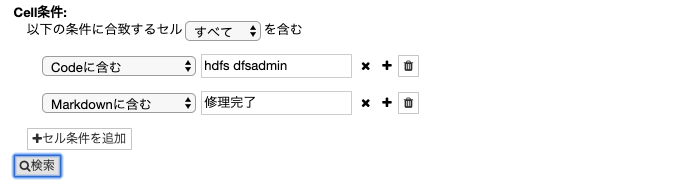

NotebookがどのようなCellを含んでいるかどうかを指定して検索することができます。
Cellに関する条件は複数設定することができます。横方向に+ボタンで追加すると、あるCellが満たすべき条件を追加することができます。また、縦方向に +セル条件を追加 を行うと、独立したCell条件を追加することができます。

* *すべて* / *いずれか* 含む ... セルの検索条件(N個)をAND/OR検索いずれで行うか。
* Cellの検索条件 ... *MEME完全一致* / *先行MEME完全一致* / *後続MEME完全一致* / *MEMEに含む* / *先行MEMEに含む* / *後続MEMEに含む* / *Codeに含む* / *Markdownに含む* / *Outputに含む* / *MEME一致しない* / *先行MEME一致しない* / *後続MEME一致しない* / *MEMEに含まない* / *先行MEMEに含まない* / *後続MEMEに含まない* / *Codeに含まない* / *Markdownに含まない* / *Outputに含まない*


### 検索結果の確認

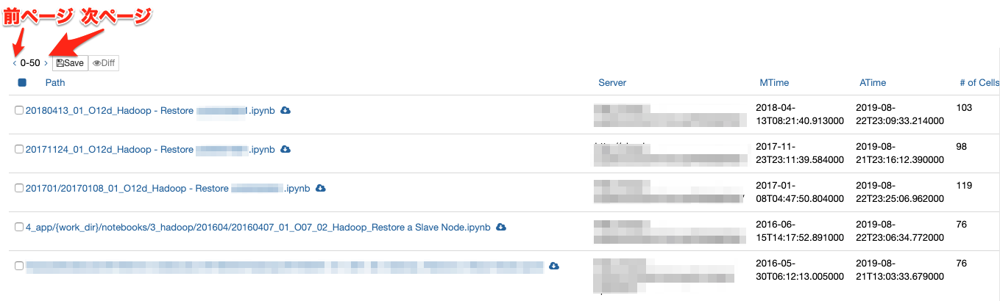

* ページの切り替え ... 検索結果が50を超える場合、 < > でページを切り替えることができます
* Save ... `NBSearchヒストリ` に検索結果を保存します。
* Diff ... 比較したいNotebookを検索結果からチェックボックスにより選択することで、 Notebook比較 を行うことができます。

#### Notebookのダウンロード

検索結果のパス名をクリックすると、Notebookを開くことができます。nbsearch-tmpというフォルダがNotebookフォルダ配下に作成され、そこに一時的にダウンロードされます。
ダウンロードボタン(雲↓)をクリックすると、現在のJupyterツリーで開いているフォルダ(Filesタブで確認できます)にNotebookをダウンロードし、開くことができます。

## NBSearchヒストリ

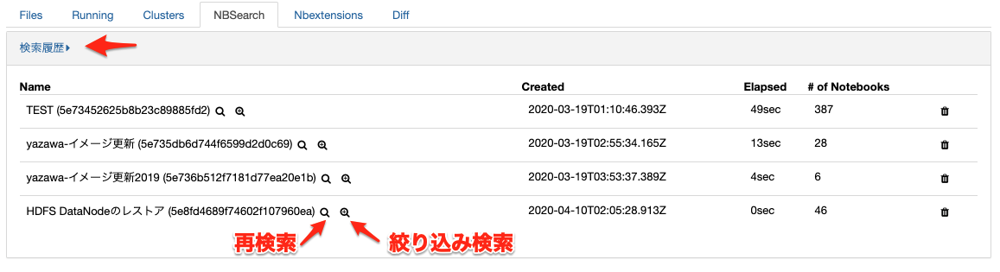

検索履歴バーをクリックすると、検索履歴の一覧を確認することができます。

* 再検索 ... ヒストリと同じ検索条件でNotebookを検索しなおします
* 絞り込み検索 ... ヒストリに保存されたNotebookに対して、検索を実施します